In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/final_grape_data.zip

Archive:  /content/drive/MyDrive/final_grape_data.zip
   creating: final_grape_data/image/
  inflating: final_grape_data/image/1 (1).png  
  inflating: final_grape_data/image/1 (10).png  
  inflating: final_grape_data/image/1 (100).png  
  inflating: final_grape_data/image/1 (101).png  
  inflating: final_grape_data/image/1 (102).png  
  inflating: final_grape_data/image/1 (103).png  
  inflating: final_grape_data/image/1 (104).png  
  inflating: final_grape_data/image/1 (105).png  
  inflating: final_grape_data/image/1 (106).png  
  inflating: final_grape_data/image/1 (107).png  
  inflating: final_grape_data/image/1 (108).png  
  inflating: final_grape_data/image/1 (109).png  
  inflating: final_grape_data/image/1 (11).png  
  inflating: final_grape_data/image/1 (110).png  
  inflating: final_grape_data/image/1 (111).png  
  inflating: final_grape_data/image/1 (112).png  
  inflating: final_grape_data/image/1 (113).png  
  inflating: final_grape_data/image/1 (114).png  
  inflating: 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D,BatchNormalization
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as keras
import os
import cv2

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

In [ ]:
def unet(input_size = (128,128,3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2DTranspose(512,2,strides=(2,2),padding='same')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2DTranspose(256,2,strides=(2,2),padding='same')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2DTranspose(128,2,strides=(2,2),padding='same')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2DTranspose(64,2,strides=(2,2),padding='same')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
def read_and_preprocess_images(folder_path, target_size=(128, 128), grayscale=False):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_path = os.path.join(folder_path, filename)
            if grayscale:
                image = cv2.imread(image_path, 0)
                image = np.expand_dims(image, axis=-1)
            else:
                image = cv2.imread(image_path)
            image = image.astype(np.float32) / 255.0
            image = cv2.resize(image, target_size)
            images.append(image)
    return np.array(images)

In [ ]:
images = read_and_preprocess_images('/content/final_grape_data/image', target_size=(128, 128))
masks = read_and_preprocess_images('/content/final_grape_data/mask', target_size=(128, 128), grayscale=True)

In [ ]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(images,masks,test_size=0.2,train_size=0.8,random_state=1)
images_train = np.array(images_train)
masks_train = np.array(masks_train)
images_test = np.array(images_test)
masks_test = np.array(masks_test)

In [ ]:
model=unet()
model.fit(images_train, masks_train, validation_data=(images_test, masks_test), batch_size=16, epochs=40, verbose=1)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_40 (Conv2D)          (None, 128, 128, 64)         1792      ['input_3[0][0]']             
                                                                                                  
 conv2d_41 (Conv2D)          (None, 128, 128, 64)         36928     ['conv2d_40[0][0]']           
                                                                                                  
 max_pooling2d_8 (MaxPoolin  (None, 64, 64, 64)           0         ['conv2d_41[0][0]']           
 g2D)                                                                                       

In [ ]:
results = model.predict(images_test)
pred_mask = np.squeeze(np.where(results > 0.5, 1, 0), axis=-1)

6/6 [==============================] - 1s 122ms/step


In [ ]:
loss, acc = model.evaluate(images_test, masks_test)
loss, acc

6/6 [==============================] - 1s 102ms/step - loss: 0.0399 - accuracy: 0.9702


(0.03993012383580208, 0.9701626300811768)

In [ ]:
model.save('unet2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


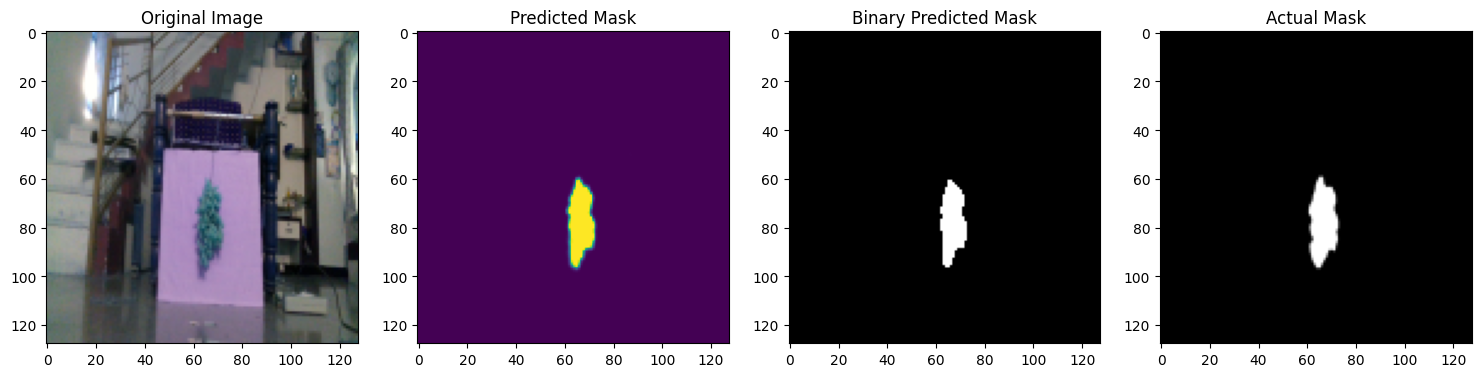

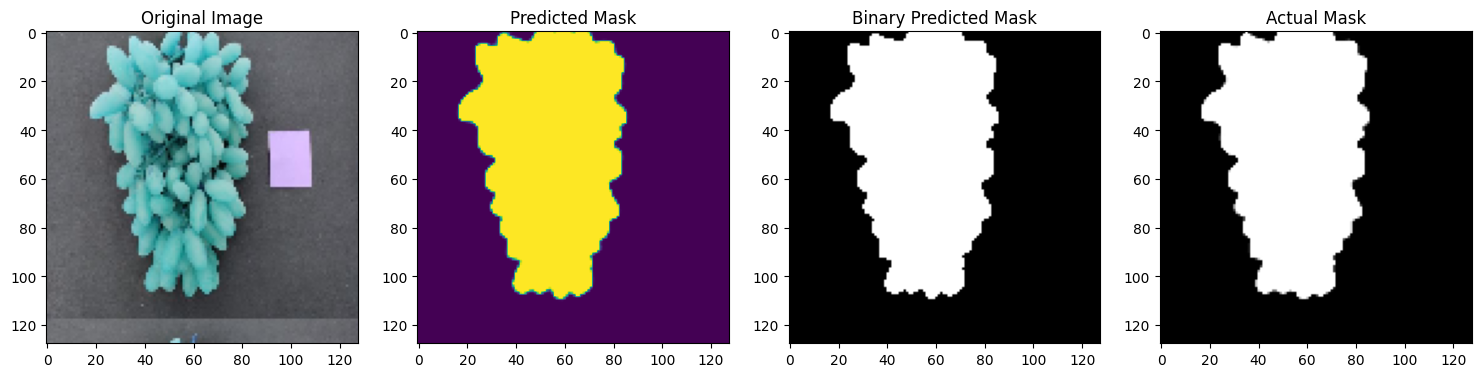

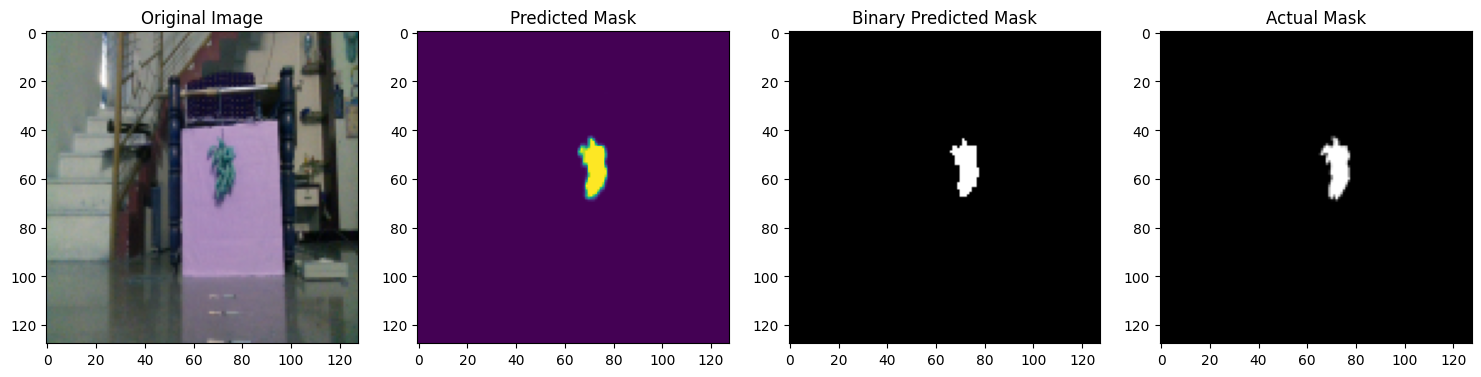

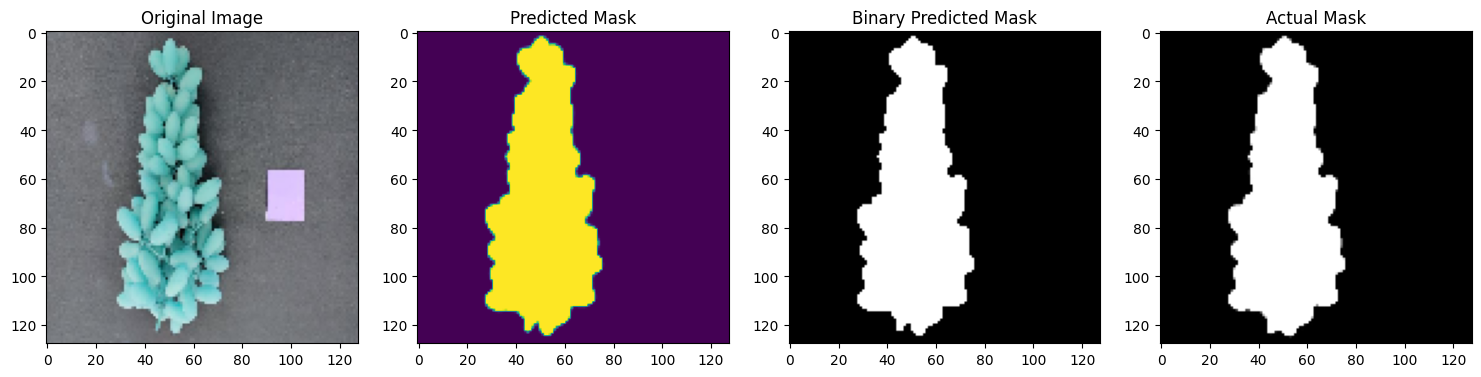

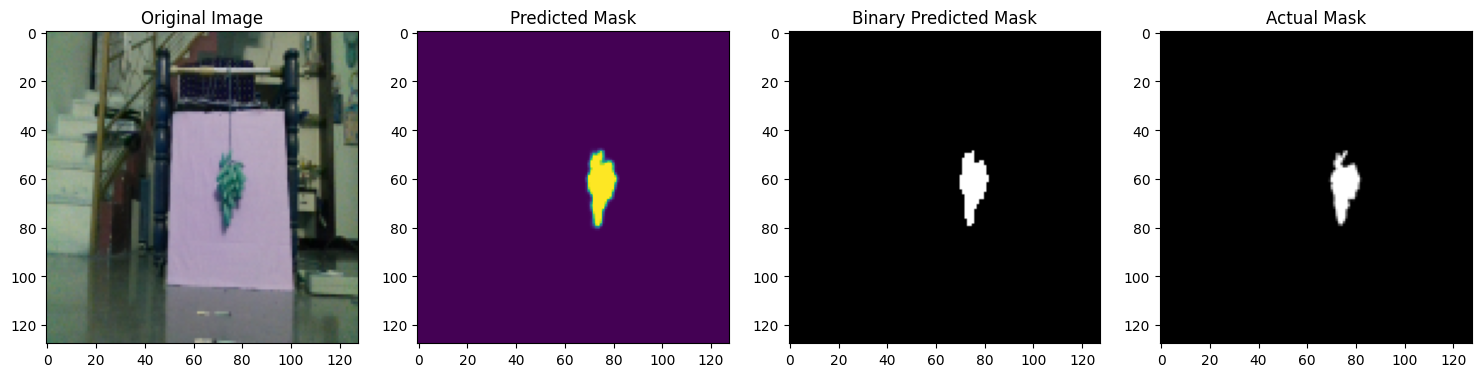

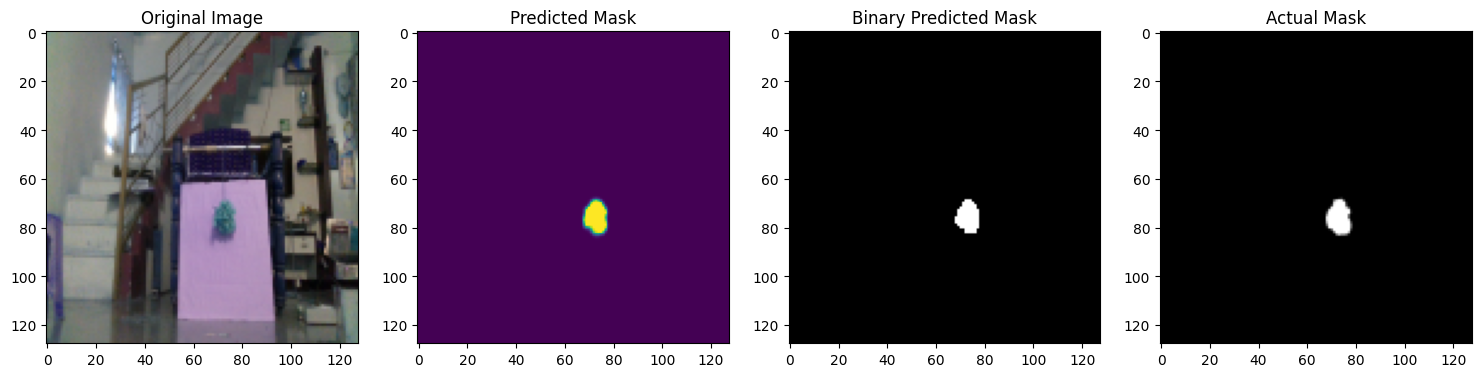

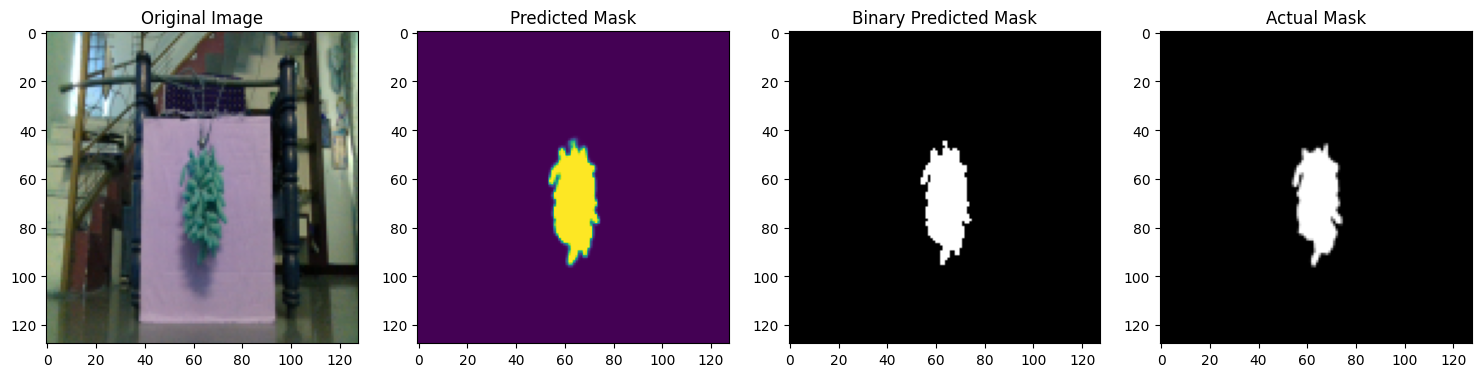

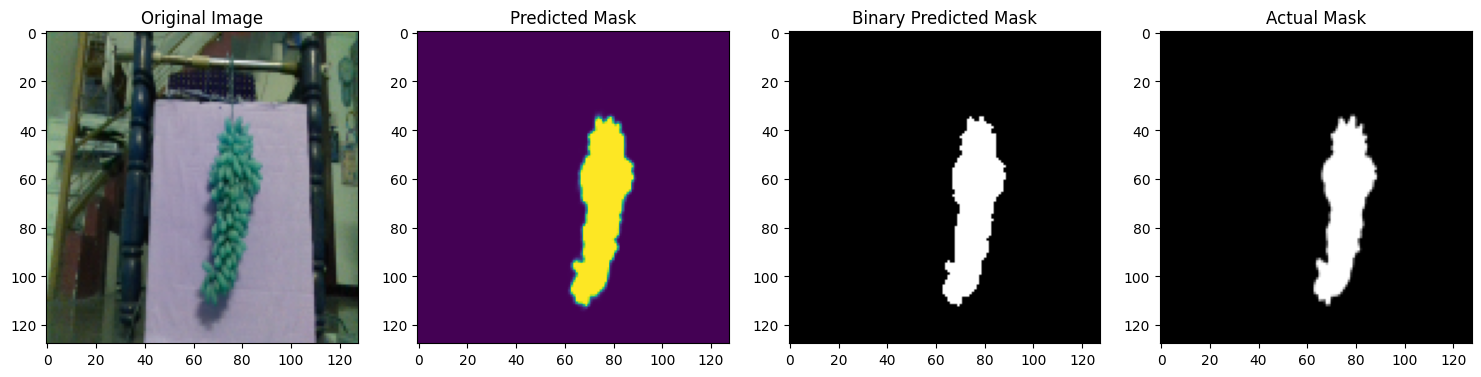

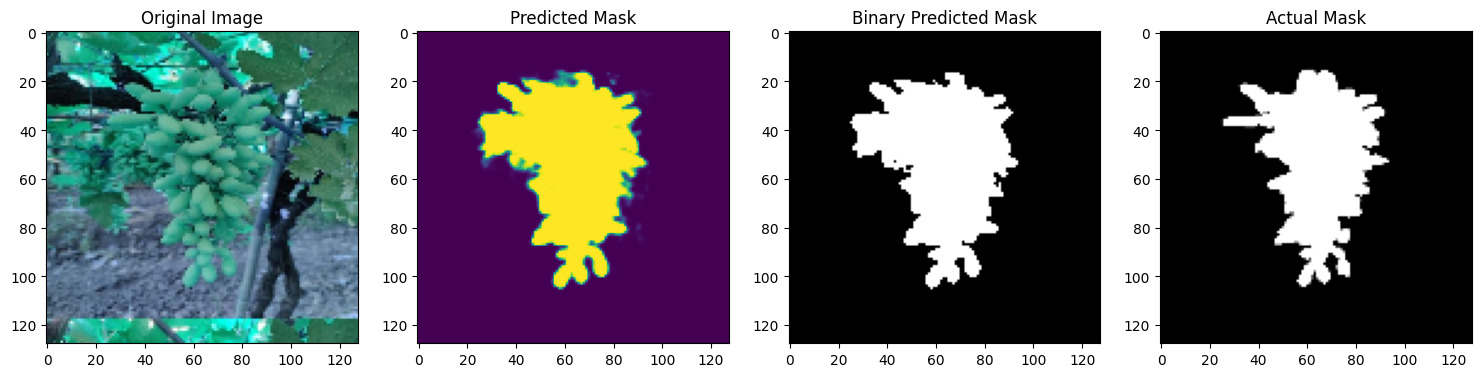

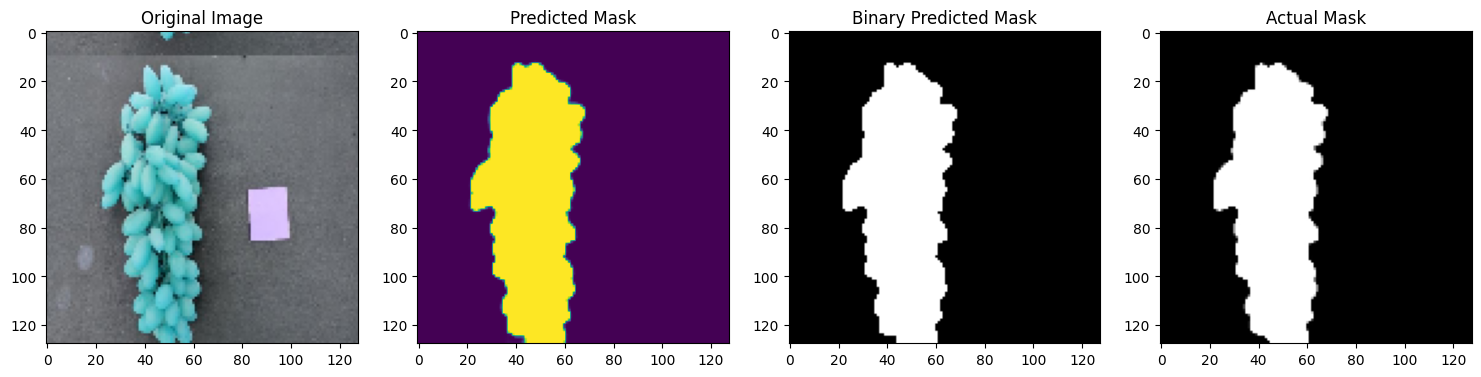

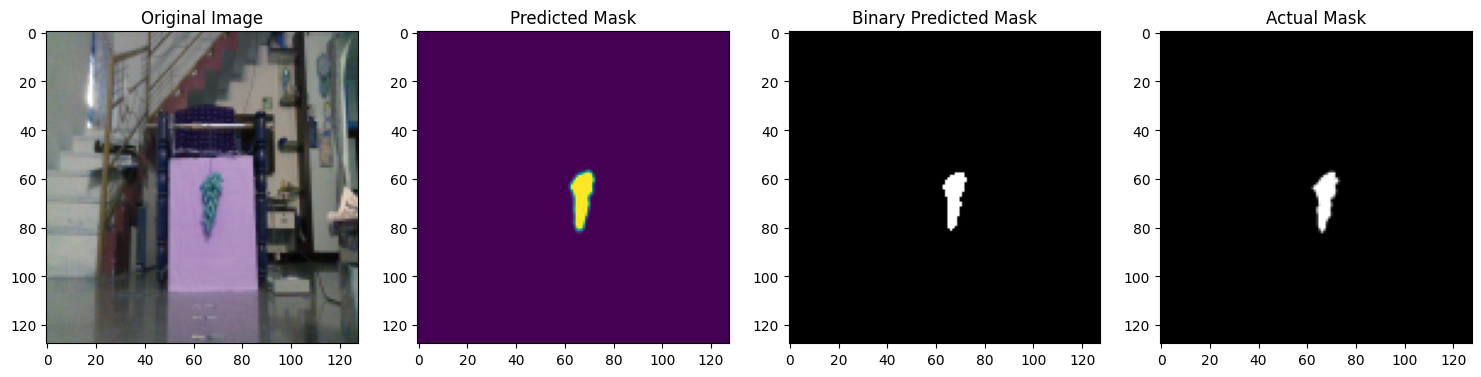

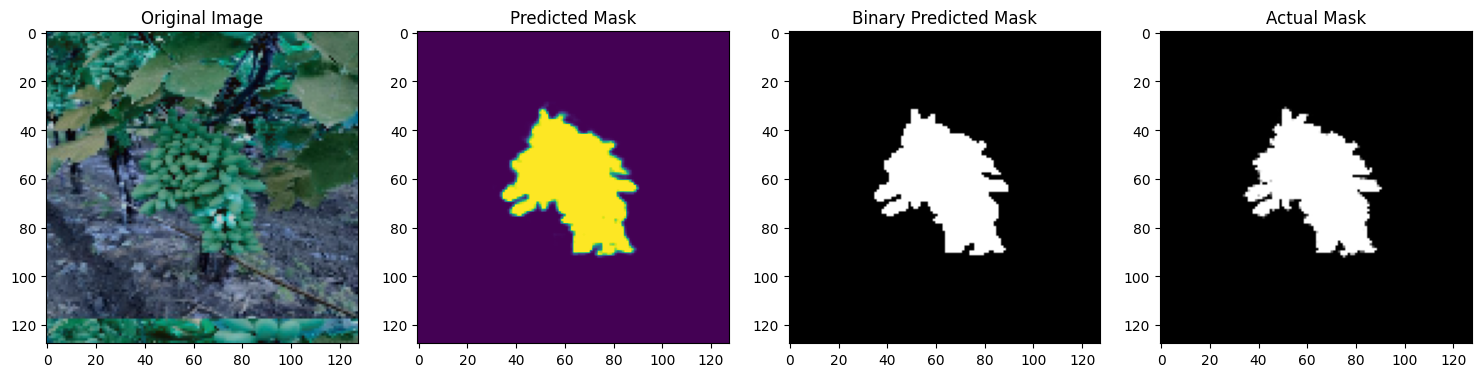

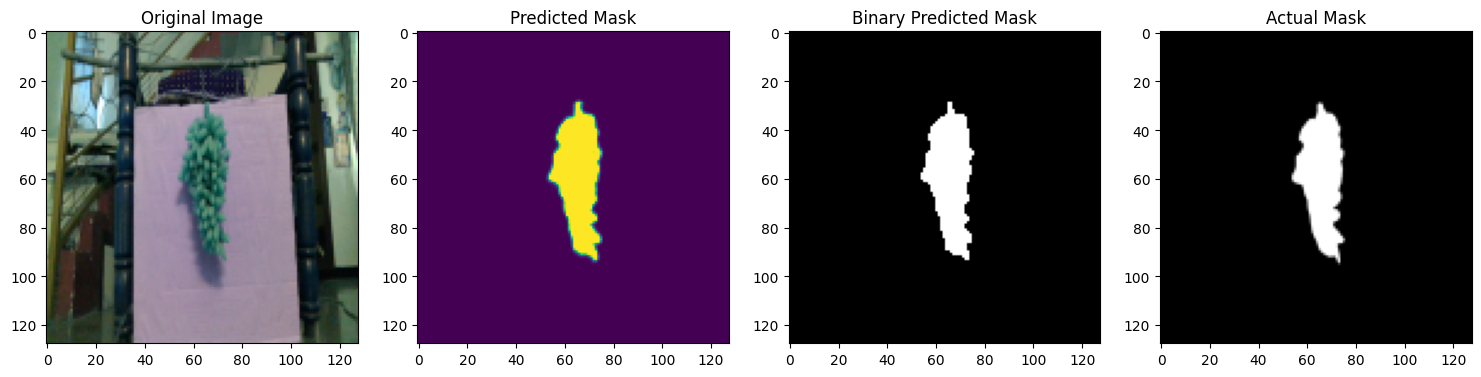

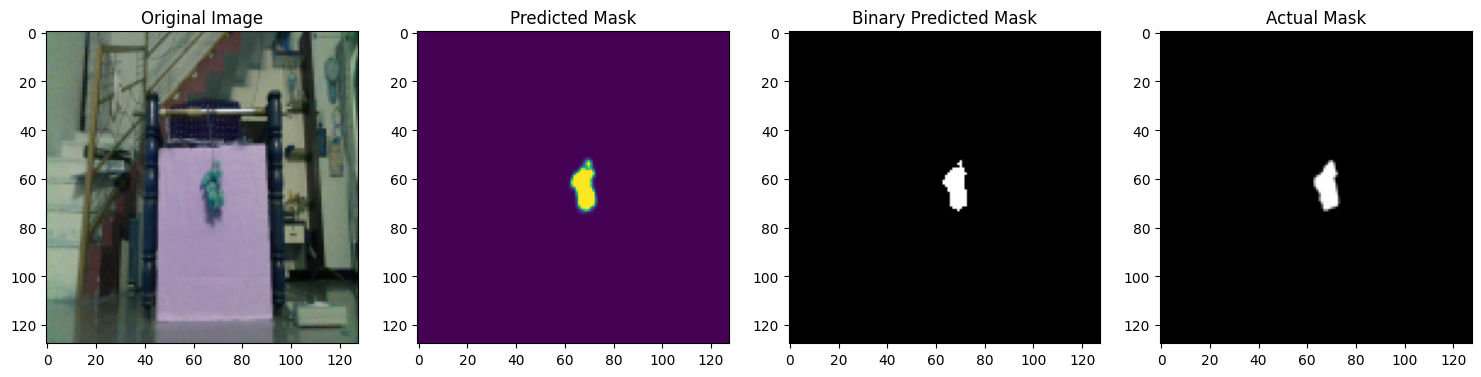

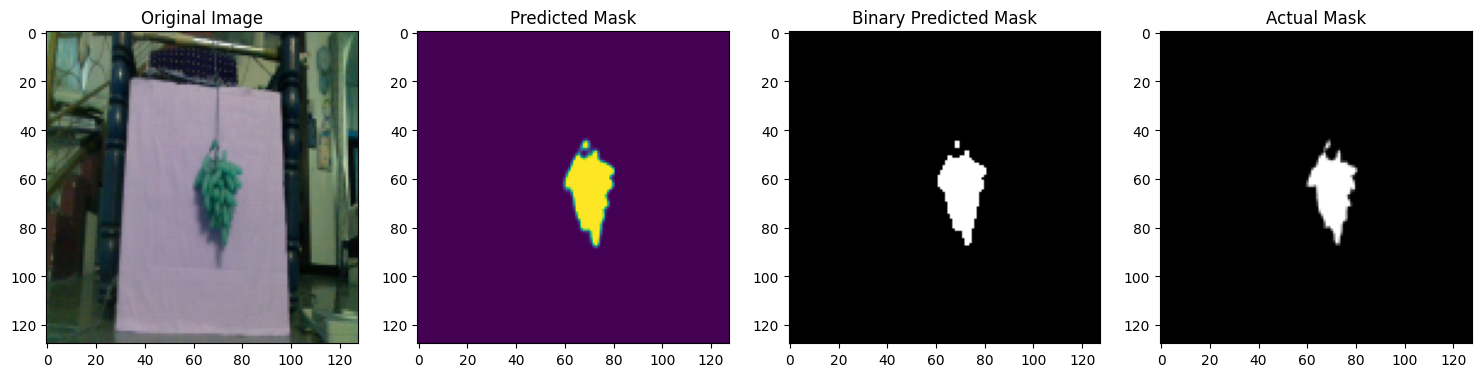

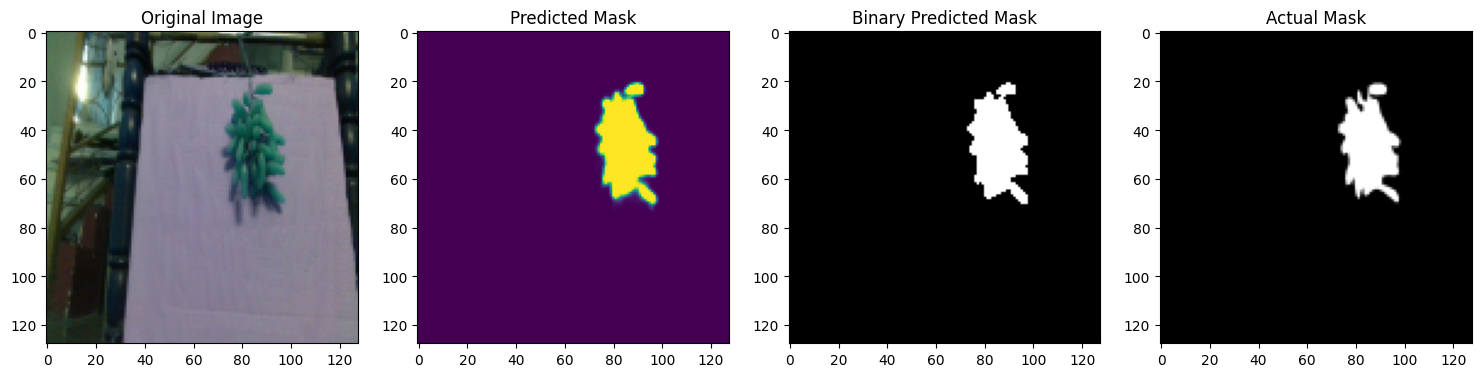

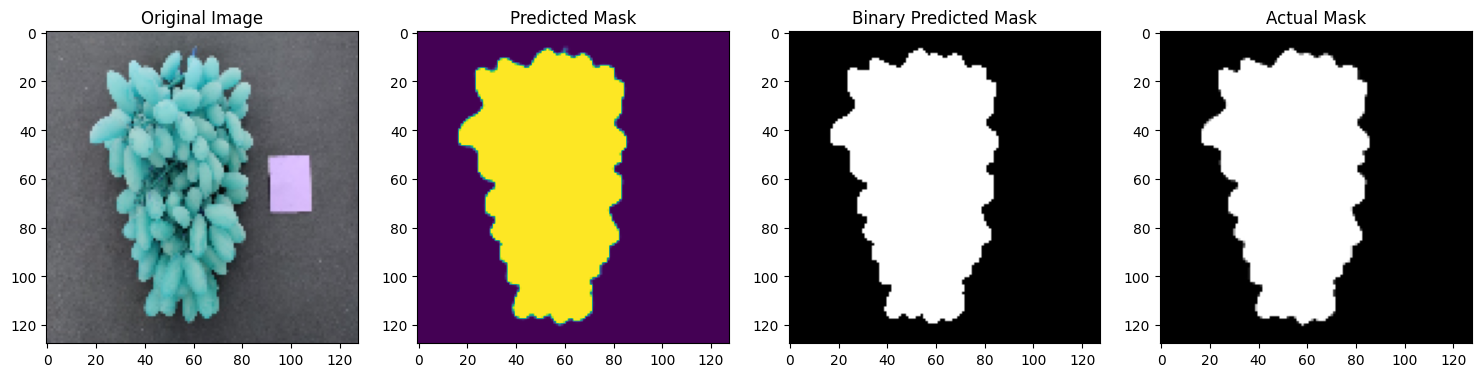

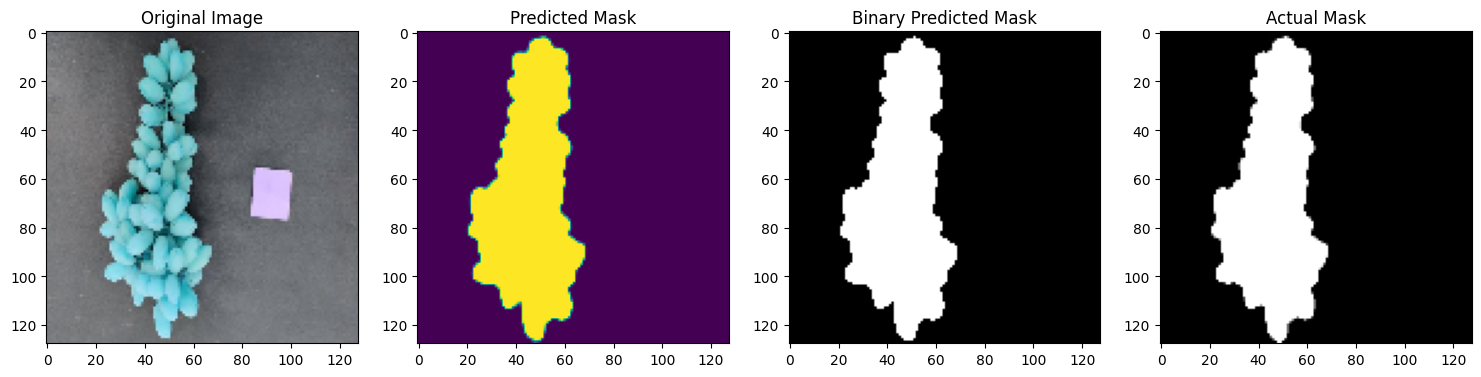

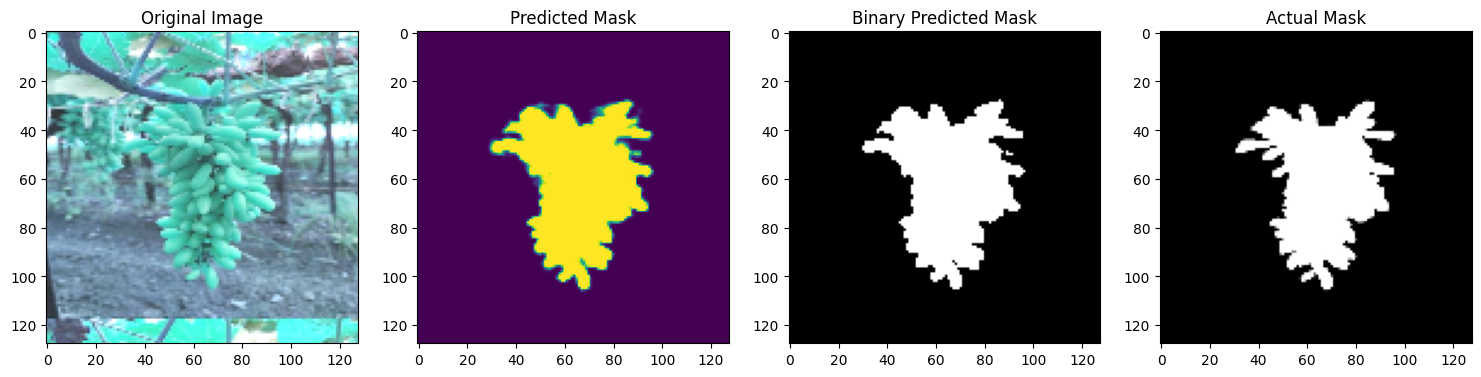

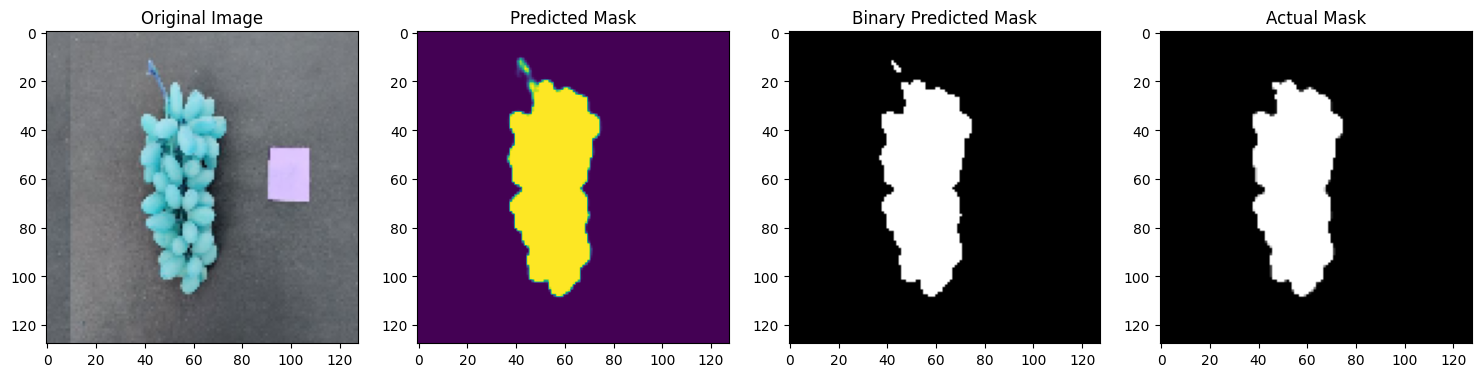

In [ ]:
for i in range(20):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(images_test[i])
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(results[i])
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask[i], cmap='gray')
    plt.title('Binary Predicted Mask')

    plt.subplot(1, 4, 4)
    plt.imshow(masks_test[i], cmap='gray')
    plt.title('Actual Mask')
    plt.tight_layout()
    plt.show()

In [ ]:
def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou = np.sum(intersection) / np.sum(union)
    return iou

def compute_dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_coefficient = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_coefficient


iou = compute_iou(pred_mask, masks_test)
dice_coefficient = compute_dice_coefficient(pred_mask, masks_test)

print("IoU:", iou)
print("Dice Coefficient:", dice_coefficient)

IoU: 0.8975697780085681
Dice Coefficient: 0.9789214211427947


In [ ]:
def compute_dice_loss(y_true, y_pred):
    dice_loss = 1 - compute_dice_coefficient(y_true, y_pred)
    return dice_loss

def compute_focal_loss(y_true, y_pred, gamma=2.0, alpha=0.25):
    epsilon = 1e-7
    y_pred = np.clip(y_pred, epsilon, 1.0 - epsilon)
    focal_loss = - (alpha * y_true * ((1 - y_pred) ** gamma) * np.log(y_pred) +
                    (1 - alpha) * (1 - y_true) * (y_pred ** gamma) * np.log(1 - y_pred))
    return focal_loss.mean()

dice_loss = compute_dice_loss(pred_mask, masks_test)
focal_loss = compute_focal_loss(pred_mask, masks_test)

print("Dice Loss:", dice_loss)
print("Focal Loss:", focal_loss)

Dice Loss: 0.02107857885720532
Focal Loss: 0.01239601882451871
